<a href="https://colab.research.google.com/github/enikolaev/MMO/blob/main/Lesson%2004.%20Logic%20Classification/LabWork4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 4. Логические методы классификации

In [1]:
!wget https://raw.githubusercontent.com/enikolaev/MMO/main/datasets/iris/iris.data

--2024-02-09 17:32:47--  https://raw.githubusercontent.com/enikolaev/MMO/main/datasets/iris/iris.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [text/plain]
Saving to: ‘iris.data’

iris.data           100%[===================>]   4.44K  --.-KB/s    in 0s      

2024-02-09 17:32:47 (42.5 MB/s) - ‘iris.data’ saved [4551/4551]



In [2]:
import numpy as np
import pandas as pd

%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt

data_source = 'iris.data'
d = pd.read_table(data_source, delimiter=',',
                  header=None,
                  names=['sepal_length','sepal_width',
                         'petal_length','petal_width','answer'])
dX = d.iloc[ : , 0:4 ]
dy = d['answer']
print(dX.head())
print(dy.head())

   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: answer, dtype: object


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = \
train_test_split(dX, dy, test_size=0.3, random_state=12)

# Обучение модели
tree = DecisionTreeClassifier(max_depth=5,
                              random_state=21,
                              max_features=2)
tree.fit(X_train, y_train)

# Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.9777777777777777


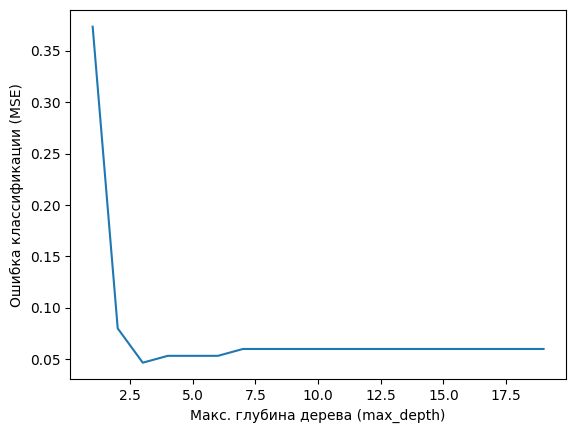

Оптимальные значения max_depth:  [3]


In [4]:
from sklearn.model_selection import cross_val_score

# Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения K
for d in d_list:
    tree = DecisionTreeClassifier(max_depth=d,
                                  random_state=21,
                                  max_features=2)
    scores = cross_val_score(tree, dX, dy, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]

# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

# печатаем все K, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

In [11]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
tree_grid.fit(dX, dy)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

# Генерируем графическое представление дерева (сохранится в файле)
tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file='iris_tree.dot',
                     filled=True, rounded=True)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 2, 'max_features': 3}
Лучшие баллы cross validation:  0.9533333333333334


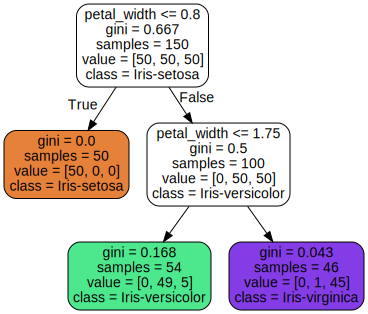

In [12]:
# На самом деле можно визуализировать в Google Colab следующим бразом
import graphviz
dot_data = tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file=None,
                     filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [16]:
# Построим модель для оптимального дерева
# max_features = 2, max_depth = 3
dtc = DecisionTreeClassifier(max_depth=3,
                             random_state=21,
                             max_features=2)
# Обучаем
dtc.fit(dX.values, dy)
# Предсказываем
res = dtc.predict([[5.1, 3.5, 1.4, 0.2]])
print(res)

['Iris-setosa']
<class 'pandas.core.frame.DataFrame'>


Построим границы решений для модели

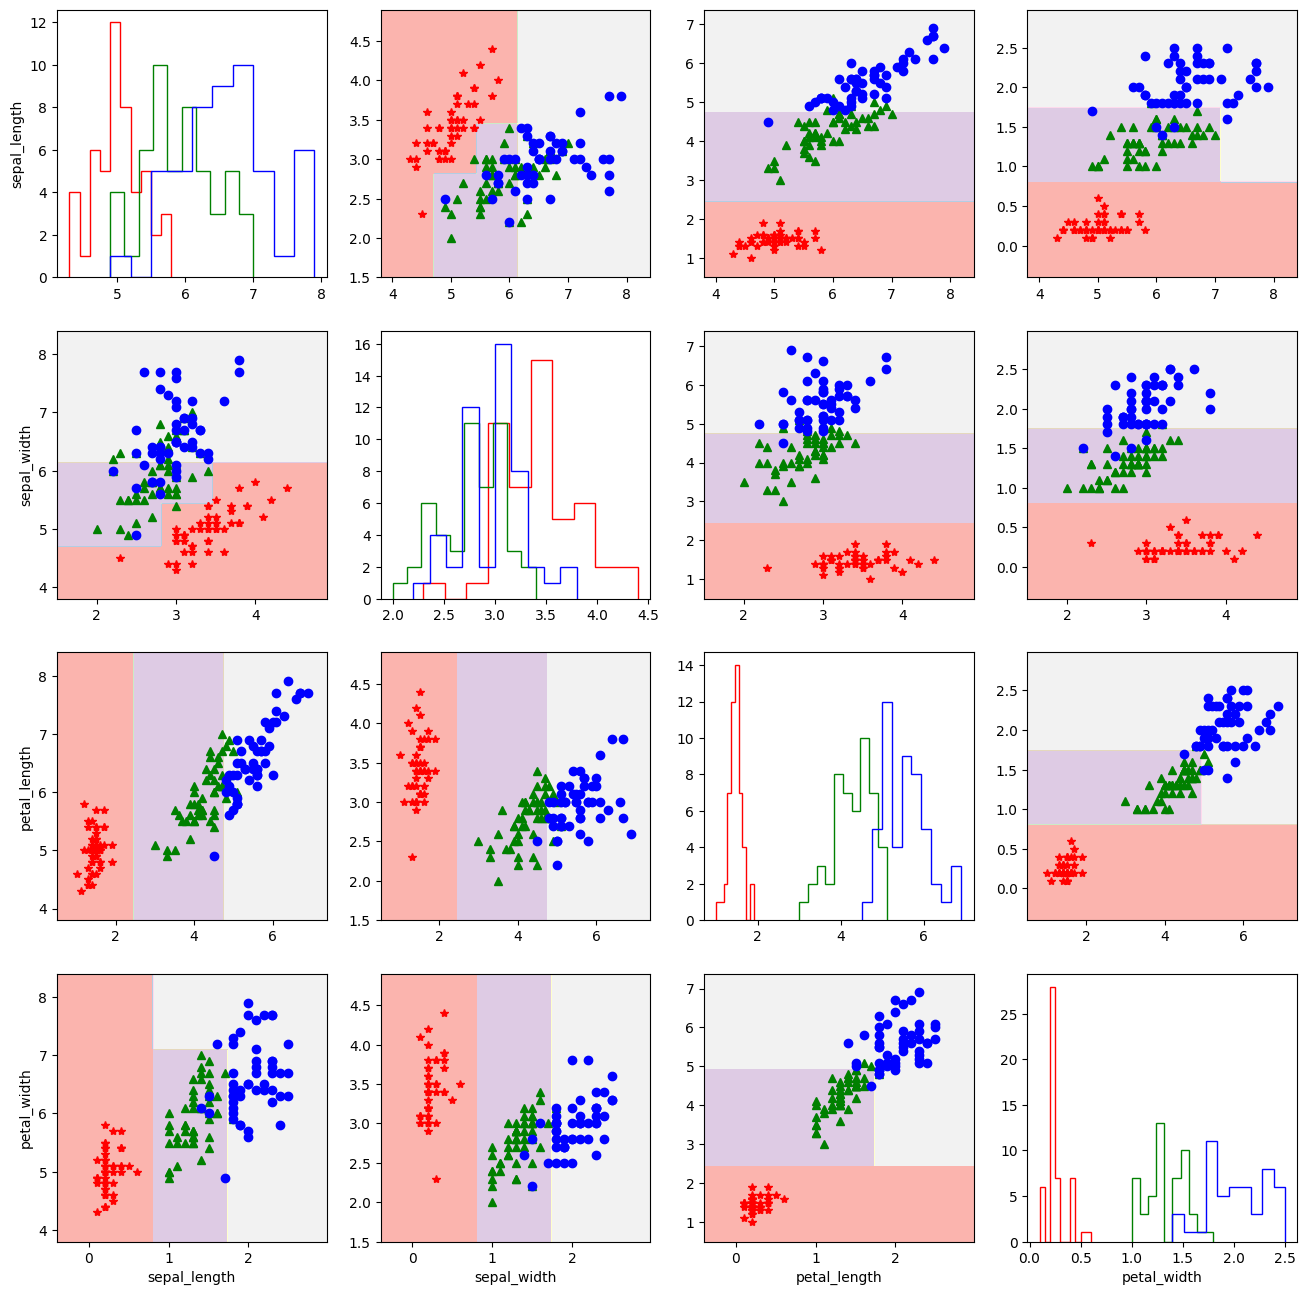

In [70]:
plot_markers = ['r*', 'g^', 'bo']
answers = dy.unique()
labels = dX.columns.values
# Создаем подграфики для каждой пары признаков
f, places = plt.subplots(4, 4, figsize=(16,16))

fmin = dX.min().values-0.5
fmax = dX.max().values+0.5
plot_step = 0.02

# Обходим все subplot
for i in range(0,4):
    for j in range(0,4):

        # Строим решающие границы
        if(i != j):
            xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step, dtype=float),
                               np.arange(fmin[j], fmax[j], plot_step, dtype=float))
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            model.fit(dX.iloc[:, [i,j]].values, dy.values)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            p[p==answers[0]] = 0
            p[p==answers[1]] = 1
            p[p==answers[2]] = 2
            p=p.astype('int32')
            places[i,j].contourf(xx, yy, p, cmap=plt.cm.)

        # Обход всех классов (Вывод обучающей выборки)
        for id_answer in range(len(answers)):
            idx = np.where(dy == answers[id_answer])
            if i==j:
                places[i, j].hist(dX.iloc[idx].iloc[:,i],
                                  color=plot_markers[id_answer][0],
                                 histtype = 'step')
            else:
                places[i, j].plot(dX.iloc[idx].iloc[:,i], dX.iloc[idx].iloc[:,j],
                                  plot_markers[id_answer],
                                  label=answers[id_answer], markersize=6)

        # Печать названия осей
        if j==0:
          places[i, j].set_ylabel(labels[i])

        if i==3:
          places[i, j].set_xlabel(labels[j])


